# Universal Regression Model

### Importing libraries and define functions

In [1]:
import pandas as pd
import numpy as np
import scipy
import math
import os
import sys

In [2]:
# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

In [3]:
import sklearn
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [4]:
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from yellowbrick.model_selection import FeatureImportances
import matplotlib.pyplot as plt

In [5]:
from pycaret.regression import *

In [6]:
import functions as f

In [7]:
from copy import deepcopy

In [8]:
categorical_columns = ['NP_type', 'Coating','shape','Cell_name','Cell_species','cell_Organ','Cell_morphology',
                       'Cell_age','cell_type','sex','Assay','Test_indicator']
numerical_columns = ['core_size_nm','hydro_size_nm','Surf_charge_mV','Surface_area_m2_g','Dose_microg_mL','Duration_h',
                    'Viability']

numerical_columns_no_target = ['core_size_nm','hydro_size_nm','Surf_charge_mV','Surface_area_m2_g','Dose_microg_mL','Duration_h']

### Loading the train data into the data frame.

In [9]:
data_train_df = pd.read_csv("output/datasets/universal/data_regression_train_df.csv", encoding="utf-8")

In [10]:
data_train_df.dtypes

NP_type                object
Coating                object
core_size_nm          float64
hydro_size_nm         float64
Surf_charge_mV        float64
Surface_area_m2_g     float64
shape                  object
Dose_microg_mL        float64
Duration_h            float64
Cell_name              object
Cell_species           object
cell_Organ             object
Cell_morphology        object
Cell_age               object
cell_type              object
sex                    object
Assay                  object
Test_indicator         object
nanomaterial_group     object
Viability             float64
dtype: object

In [11]:
data_train_df.shape

(3724, 20)

In [12]:
data_train_df.head()

,NP_type,Coating,core_size_nm,hydro_size_nm,Surf_charge_mV,Surface_area_m2_g,shape,Dose_microg_mL,Duration_h,Cell_name,Cell_species,cell_Organ,Cell_morphology,Cell_age,cell_type,sex,Assay,Test_indicator,nanomaterial_group,Viability
0,CuO,None,12.80,305.3,7.60,NaN,NaN,6.3,NaN,BEAS_2B,Human,Lung,Epithelial,Adult,Normal,NaN,MTS,TetrazoliumSalt,meta_oxide,82.00
1,PLGA,PVA,182.00,NaN,-3.50,NaN,Sphere,500.0,4.0,Calu-3,Human,Lung,Epithelial,Adult,cancer,male,MTT,TetrazoliumSalt,other,94.29
2,CuO,None,46.30,239.0,42.80,24.1,NaN,0.0,24.0,HCMEC,Human,Heart,Endothelial,Adult,Normal,NaN,MTT,TetrazoliumSalt,meta_oxide,96.13
3,Hydroxyapatite,None,20.00,NaN,-5.30,NaN,Rod,10.0,24.0,RAW 264.7,Mouse,Blood,Macrophage,Adult,cancer,male,CCK_8,TetrazoliumSalt,other,104.89
4,Au,Citrate_based,61.06,NaN,-30.55,NaN,Sphere,1.0,24.0,CCL-110,Human,Skin,Fibroblast,fetus,Normal,female,MTS,TetrazoliumSalt,other,94.17


In [13]:
#data_train_df_clean = data_train_df.dropna(thresh=data_train_df.shape[1]-3, axis=0)
#print(data_train_df_clean.shape)

### Loading the test data into the data frame.

In [14]:
data_test_df = pd.read_csv("output/datasets/universal/data_regression_test_df.csv", encoding="utf-8")

In [15]:
data_test_df.dtypes

NP_type                object
Coating                object
core_size_nm          float64
hydro_size_nm         float64
Surf_charge_mV        float64
Surface_area_m2_g     float64
shape                  object
Dose_microg_mL        float64
Duration_h            float64
Cell_name              object
Cell_species           object
cell_Organ             object
Cell_morphology        object
Cell_age               object
cell_type              object
sex                    object
Assay                  object
Test_indicator         object
nanomaterial_group     object
Viability             float64
dtype: object

In [16]:
data_test_df.shape

(932, 20)

In [17]:
data_test_df.head()

,NP_type,Coating,core_size_nm,hydro_size_nm,Surf_charge_mV,Surface_area_m2_g,shape,Dose_microg_mL,Duration_h,Cell_name,Cell_species,cell_Organ,Cell_morphology,Cell_age,cell_type,sex,Assay,Test_indicator,nanomaterial_group,Viability
0,IronOxide,OleicAcid,10.9,183.60,-28.50,NaN,Sphere,25.0,6.0,SH­SY5Y,Human,BoneMarrow,Epithelial,Young,cancer,female,NR,toluylene red,meta_oxide,104.59
1,Al2O3,None,39.7,NaN,36.30,NaN,Sphere,0.1,24.0,HCMEC,Human,Heart,Endothelial,Adult,Normal,NaN,MTT,TetrazoliumSalt,meta_oxide,93.77
2,IronOxide,Folic_acid_based,80.0,420.55,-27.70,NaN,NaN,0.0,24.0,SKOV­3,Human,Ovary,Epithelial,Young,cancer,female,MTT,TetrazoliumSalt,meta_oxide,91.92
3,ZnO,None,100.0,258.55,-9.96,NaN,Sphere,80.0,24.0,SH­SY5Y,Human,BoneMarrow,Epithelial,Young,cancer,female,NR,toluylene red,meta_oxide,49.35
4,MgO,None,NaN,NaN,-7.21,NaN,Hexagon,400.0,24.0,VERO,Monkey,Kidney,Epithelial,Adult,Normal,female,MTT,TetrazoliumSalt,meta_oxide,70.96


In [18]:
#data_test_df_clean = data_test_df.dropna(thresh=data_test_df.shape[1]-3, axis=0)
#print(data_test_df_clean.shape)

### Use the best scenario identified in step 01

In [19]:
sc_ignore_features = None
sc_high_cardinality_features = None

sc_imputation_type = 'simple'
sc_numeric_imputation = 'mean'

sc_normalize = True
sc_remove_outliers = False

### Define seeds

In [20]:
cv_inner_seed = 123456
cv_outer_seed = 123

### The Universal Regression Model: Data Preprcoessing

In [21]:
stup = setup(data = data_train_df, target = 'Viability', 
              
        test_data = data_test_df,
             
        categorical_features=categorical_columns,
        numeric_features=numerical_columns_no_target,

        imputation_type = sc_imputation_type, 
        numeric_imputation = sc_numeric_imputation, #default: mean

        ignore_features = sc_ignore_features,
        bin_numeric_features = None,
        high_cardinality_features = sc_high_cardinality_features,

        normalize = sc_normalize, #default: False
        remove_outliers= sc_remove_outliers, #default: False

        transformation= False, #default
        transformation_method = 'yeo-johnson', #default
        transform_target = False, 
        combine_rare_levels = False,
        rare_level_threshold = 0.1, #default: 0.1

        remove_multicollinearity = False, #default 
        multicollinearity_threshold = 0.9, #default

        ignore_low_variance = True, 

        feature_interaction = False, 
        feature_ratio = False,
        polynomial_features = False, 
        trigonometry_features = False,
          
        fold = 5,

        # don't change the following
        session_id = cv_inner_seed,
        use_gpu=False,
        log_experiment = False,
        silent=True,
        experiment_name = 'universal')

set_config('seed', cv_inner_seed)

,Description,Value
0,session_id,123456
1,Target,Viability
2,Original Data,"(3724, 20)"
3,Missing Values,True
4,Numeric Features,6
5,Categorical Features,13
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(3724, 249)"


In [22]:
print(get_config(variable="X_train").shape)
print(get_config(variable="y_train").shape)

(3724, 249)
(3724,)


In [23]:
print(get_config(variable="X").shape)
print(get_config(variable="y").shape)

(3724, 249)
(3724,)


In [24]:
#set_config('X_train', get_config(variable="X").copy()) 
#set_config('y_train', get_config(variable="y").copy()) 
#print(get_config(variable="X_train").shape)
#print(get_config(variable="y_train").shape)

In [25]:
print(get_config(variable="X_test").shape)
print(get_config(variable="y_test").shape)

(932, 249)
(932,)


In [26]:
#load_config('output/models/universal_regression_config.cfg')

In [27]:
data_train_transformed_df = get_config(variable="X").copy()
data_train_transformed_df['Viability'] = get_config(variable="y").copy()

In [28]:
data_test_transformed_df = get_config(variable="X_test").copy()
data_test_transformed_df['Viability'] = get_config(variable="y_test").copy()

In [29]:
data_train_transformed_df.to_csv('output/datasets/universal/transformed/data_regression_train_transformed_df.csv', encoding='utf-8', index=False)
data_test_transformed_df.to_csv('output/datasets/universal/transformed/data_regression_test_transformed_df.csv', encoding='utf-8', index=False)

## Double cross-validation

### Inner CV: 5-fold cross-validation for model selection / hyperparameter tuning for 8 models

In [30]:
model_names = ['lr', 'lasso', 'ridge', 'svm', 'rf', 'et', 'gbr', 'lightgbm']
#model_names = ['lr']

In [31]:
inner_results = dict()
inner_results_tuned = dict()
outer_results = dict()
predicted_results = dict()
tuned_models = dict()
final_models = dict()

In [32]:
for model_name in model_names:

    default_model = create_model(model_name, round=2)

    results_df = pull()
    results_df = results_df.reset_index(level=0)
    
    inner_results[model_name] = results_df.copy()
    results_df.to_csv("output/models_results/universal/" + "regression_model_"+model_name+"_inner_cross_validation_results.tsv", 
                    index=False, encoding="utf-8", sep="\t")


    tuned_model = tune_model(default_model, choose_better = True, search_library = 'optuna', n_iter = 50, round=2)

    results_df = pull()
    results_df = results_df.reset_index(level=0)
    
    inner_results_tuned[model_name] = results_df.copy()
    results_df.to_csv("output/models_results/universal/" + "regression_model_"+model_name+"_tuned_inner_cross_validation_results.tsv", 
                    index=False, encoding="utf-8", sep="\t")
    
    tuned_models[model_name] = deepcopy(tuned_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,9.70,235.23,15.34,0.78,0.46,0.56
1,9.00,172.09,13.12,0.81,0.48,1.37
2,9.76,211.11,14.53,0.78,0.37,0.34
3,8.95,187.55,13.69,0.82,0.39,0.47
4,9.81,221.14,14.87,0.78,0.42,0.47
Mean,9.44,205.43,14.31,0.80,0.42,0.64
Std,0.39,22.80,0.80,0.02,0.04,0.37


### Outer CV: 10-fold cross-validation for the tuned model

In [33]:
X = get_config(variable="X_train").copy()
y = get_config(variable="y_train").copy()

In [34]:
X.shape

(3724, 249)

In [35]:
y.shape

(3724,)

In [36]:
cv_outer = KFold(n_splits=10, shuffle=True, random_state=cv_outer_seed)

In [37]:
'''
for model_name in model_names:
    scores = cross_val_score(tuned_models[model_name], X, y, cv=cv_outer)
    scores = np.round(scores, 2);
    outer_results[model_name] = scores.copy()
    
    with open("output/models_results/universal/" + "regression_model_"+model_name+"_tuned_outer_cross_validation_results.tsv", 'w', newline='') as file:
        for score in scores:
            file.write(str(score) + "\n")
        
    #with open(the_filename, 'r') as f:
    #    my_list = [line.rstrip('\n') for line in f]
'''

'\nfor model_name in model_names:\n    scores = cross_val_score(tuned_models[model_name], X, y, cv=cv_outer)\n    scores = np.round(scores, 2);\n    outer_results[model_name] = scores.copy()\n    \n    with open("output/models_results/universal/" + "regression_model_"+model_name+"_tuned_outer_cross_validation_results.tsv", \'w\', newline=\'\') as file:\n        for score in scores:\n            file.write(str(score) + "\n")\n        \n    #with open(the_filename, \'r\') as f:\n    #    my_list = [line.rstrip(\'\n\') for line in f]\n'

In [38]:
for model_name in model_names:
    scores = cross_validate(tuned_models[model_name], X, y, cv=cv_outer, scoring=('r2','neg_root_mean_squared_error','neg_mean_absolute_error'))
    scores_r2 = np.round(scores['test_r2'], 2);
    scores_rmse = np.round(scores['test_neg_root_mean_squared_error'], 2);
    scores_mae = np.round(scores['test_neg_mean_absolute_error'], 2);
    outer_results[model_name] = scores.copy()
    
    with open("output/models_results/universal/" + "regression_model_"+model_name+"_tuned_outer_cross_validation_results.tsv", 'w', newline='') as file:
        file.write('R2\tRMSE\tMAE' + "\n")
        for idx, x in enumerate(scores_r2):
            file.write(str(scores_r2[idx]) + '\t' + str(scores_rmse[idx]) + '\t' + str(scores_mae[idx]) + "\n")

    print(model_name + " scores: " + ', '.join(scores_r2.astype('str')))
    print(model_name + " mean/std: " + str(np.round(scores_r2.mean(),2)) + " / " + str(np.round(scores_r2.std(), 2)))
    
    #with open(the_filename, 'r') as f:
    #    my_list = [line.rstrip('\n') for line in f]

lr scores: -72.81, 0.39, 0.41, 0.34, -10.15, 0.42, 0.41, -83.71, -59802.52, 0.41
lr mean/std: -5996.68 / 17935.31
lasso scores: 0.35, 0.28, 0.28, 0.31, 0.31, 0.29, 0.3, 0.31, 0.37, 0.3
lasso mean/std: 0.31 / 0.03
ridge scores: 0.52, 0.4, 0.41, 0.35, 0.45, 0.42, 0.41, 0.43, 0.45, 0.42
ridge mean/std: 0.43 / 0.04
svm scores: 0.53, 0.39, 0.42, 0.42, 0.49, 0.42, 0.45, 0.46, 0.58, 0.39
svm mean/std: 0.45 / 0.06
rf scores: 0.81, 0.77, 0.81, 0.78, 0.88, 0.82, 0.76, 0.83, 0.83, 0.79
rf mean/std: 0.81 / 0.03
et scores: 0.84, 0.82, 0.84, 0.82, 0.9, 0.85, 0.81, 0.87, 0.84, 0.82
et mean/std: 0.84 / 0.03
gbr scores: 0.82, 0.82, 0.85, 0.79, 0.88, 0.86, 0.78, 0.87, 0.84, 0.83
gbr mean/std: 0.83 / 0.03
[LightGBM] [Warning] bagging_fraction is set=0.9208010711051967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9208010711051967
[LightGBM] [Warning] feature_fraction is set=0.7811105331025159, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7811105331025159
[Li

### Finalize the models and evaluate on the test set

In [39]:
for model_name in model_names:

    final_model = finalize_model(tuned_models[model_name])
    
    final_models[model_name] = deepcopy(final_model)
    
    hyperparams = pd.DataFrame.from_dict(final_model.get_params(), orient='index', columns=['parameter_value'])
    hyperparams = hyperparams.reset_index(level=0)
    hyperparams.to_csv("output/models_parameters/universal/" + "regression_model_"+model_name+"_hyperparams.tsv", 
                    index=False, encoding="utf-8", sep="\t")
    
    model_predict = predict_model(final_model, data=data_test_df, round=2)
    
    results_df = pull()
    results_df = results_df.reset_index(level=0)
    
    predicted_results[model_name] = results_df.copy()
    results_df.to_csv("output/models_results/universal/" + "regression_model_"+model_name+"_test_set_validation_results.tsv", 
                    index=False, encoding="utf-8", sep="\t")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,76.94,3206489.18,1790.67,-3069.49,0.76,2.65


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,20.17,701.20,26.48,0.33,0.79,2.29


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,18.21,582.38,24.13,0.44,0.73,1.97


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Support Vector Regression,15.43,547.55,23.40,0.48,0.73,2.14


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,8.30,169.15,13.01,0.84,0.44,0.84


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,7.62,148.64,12.19,0.86,0.37,0.57


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,8.14,143.36,11.97,0.86,0.41,0.75


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,8.88,171.98,13.11,0.84,0.45,0.88


### Save models and configs

In [40]:
for model_name in model_names:
    save_config('output/models/universal/regression_config.cfg')
    save_model(tuned_models[model_name], 'output/models/universal/regression_model_'+model_name+'_tuned.mdl')
    save_model(final_models[model_name], 'output/models/universal/regression_model_'+model_name+'_final.mdl')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved


### Create Plots

In [41]:
X_test = get_config(variable="X_test").copy()
y_test = get_config(variable="y_test").copy()

In [42]:
for model_name in ['rf', 'et', 'gbr', 'lr', 'lasso', 'ridge']:
    
    #import matplotlib.pyplot as plt
    #plt.rcParams["figure.figsize"] = [16,9]

    visualizer1 = FeatureImportances(final_models[model_name], size=(800,550), topn=10)
    visualizer1.fit(X, y)
    visualizer1.show(outpath="output/plots/universal/" + "regression_model_"+model_name+"_feature_importance_plot.png",dpi = 300)

    plt.clf() 

<Figure size 800x550 with 0 Axes>

In [43]:
for model_name in model_names:

    visualizer2 = ResidualsPlot(final_models[model_name], hist=False, qqplot=True, size=(800,550))
    visualizer2.fit(X, y)
    visualizer2.score(X_test, y_test)
    visualizer2.show(outpath="output/plots/universal/" + "regression_model_"+model_name+"_residuals_plot.png",dpi = 300)
    
    plt.clf() 

<Figure size 800x550 with 0 Axes>

In [44]:
for model_name in model_names:

    visualizer3 = PredictionError(final_models[model_name], size=(800,550))
    visualizer3.fit(X, y)
    visualizer3.score(X_test, y_test)
    visualizer3.show(outpath="output/plots/universal/" + "regression_model_"+model_name+"_error_plot.png",dpi = 300)    
    
    plt.clf()

<Figure size 800x550 with 0 Axes>

### Load model

In [19]:
model_names = ['lr', 'lasso', 'ridge', 'svm', 'rf', 'et', 'gbr', 'lightgbm']

In [20]:
final_config = load_config('output/models/universal/regression_config.cfg')

In [21]:
tuned_models_load = dict()
final_models_load = dict()

In [22]:
for model_name in model_names:
    tuned_models_load[model_name] = load_model('output/models/universal/regression_model_'+model_name+'_tuned.mdl')
    final_models_load[model_name] = load_model('output/models/universal/regression_model_'+model_name+'_final.mdl')

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [23]:
vars(final_models_load['lightgbm']._final_estimator)

{'boosting_type': 'gbdt',
 'objective': None,
 'num_leaves': 225,
 'max_depth': -1,
 'learning_rate': 0.0492126940458128,
 'n_estimators': 206,
 'subsample_for_bin': 200000,
 'min_split_gain': 0.4382254035210341,
 'min_child_weight': 0.001,
 'min_child_samples': 20,
 'subsample': 1.0,
 'subsample_freq': 0,
 'colsample_bytree': 1.0,
 'reg_alpha': 1.253532007236206e-06,
 'reg_lambda': 0.000832480550309834,
 'random_state': 123456,
 'n_jobs': -1,
 'silent': 'warn',
 'importance_type': 'split',
 '_Booster': <lightgbm.basic.Booster at 0x7f84173f4c70>,
 '_evals_result': None,
 '_best_score': defaultdict(collections.OrderedDict, {}),
 '_best_iteration': None,
 '_other_params': {'feature_fraction': 0.7811105331025159,
  'bagging_fraction': 0.9208010711051967,
  'bagging_freq': 2},
 '_objective': 'regression',
 'class_weight': None,
 '_class_weight': None,
 '_class_map': None,
 '_n_features': 249,
 '_n_features_in': 249,
 '_classes': None,
 '_n_classes': None,
 'feature_fraction': 0.78111053310

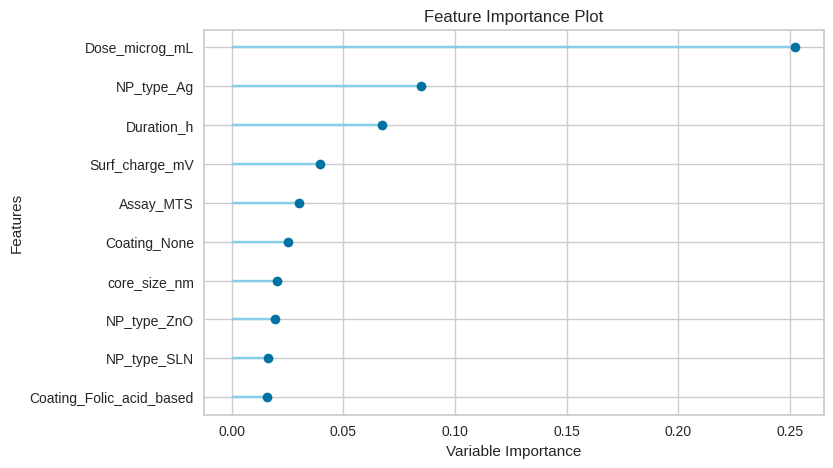

In [24]:
plot_model(final_models_load['et']._final_estimator, 'feature')

## Applicability Domain - Williams Plot

In [ ]:
res_train = predict_model(final_models_load['et'], data=data_train_df, round=2)
res_test = predict_model(final_models_load['et'], data=data_test_df, round=2)

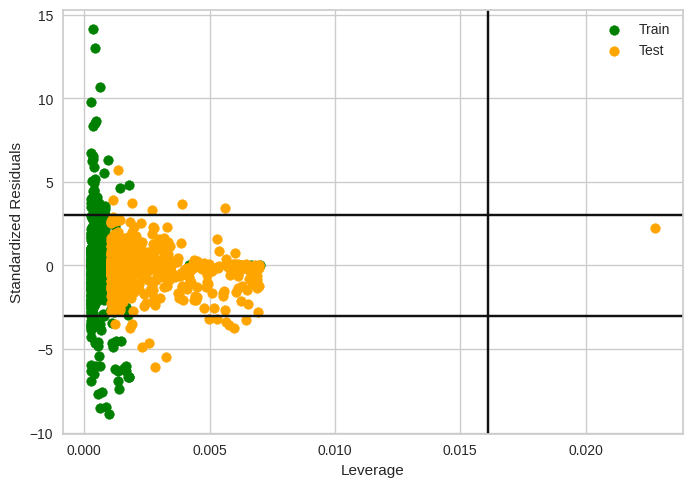

In [93]:
train_plot = f.calculate_leverage(res_train)
train_plot = f.calculate_residuals(train_plot)
train_plot = f.calculate_standard_residuals(train_plot)

test_plot = f.calculate_leverage(res_test)
test_plot = f.calculate_residuals(test_plot)
test_plot = f.calculate_standard_residuals(test_plot)

hat = data_train_df.shape[1] * 3 / data_train_df.shape[0]

fig, ax = plt.subplots()
ax.scatter(train_plot['Leverage'], train_plot['Standard Residual'], marker='o', c='green', label = 'Train')
ax.scatter(test_plot['Leverage'], test_plot['Standard Residual'], marker='o', c='orange', label = 'Test')
ax.set_xlabel('Leverage')
ax.set_ylabel('Standardized Residuals')
ax.axhline(y=3.0, xmin=0, xmax=3.0, color='k')
ax.axhline(y=-3.0, xmin=0.0, xmax=3.0, color='k')
ax.axvline(x=hat, ymin=-10.0, ymax=10.0, color='k')
ax.legend()

In [94]:
print(test_plot['Within Domain'].value_counts(normalize=True))
print(test_plot['Within Domain'].value_counts(normalize=False))

Valid    1.0
Name: Within Domain, dtype: float64
Valid    932
Name: Within Domain, dtype: int64


In [95]:
print(test_plot['Within SD'].value_counts(normalize=True))
print(test_plot['Within SD'].value_counts(normalize=False))

Valid      0.979614
Invalid    0.020386
Name: Within SD, dtype: float64
Valid      913
Invalid     19
Name: Within SD, dtype: int64


In [96]:
print(test_plot['Within Domain and SD'].value_counts(normalize=True))
print(test_plot['Within Domain and SD'].value_counts(normalize=False))

Valid      0.979614
Invalid    0.020386
Name: Within Domain and SD, dtype: float64
Valid      913
Invalid     19
Name: Within Domain and SD, dtype: int64
